## 1. Подготовка данных


In [ ]:
import numpy as np
import pandas as pd
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"


    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
data, attrs = fetch_dataset()

In [ ]:
attrs[(attrs['Black']>1) & (attrs['Smiling']>1)].index.values.tolist()

[517,
 637,
 639,
 1121,
 1451,
 1606,
 1613,
 1986,
 2574,
 2848,
 3170,
 3181,
 3872,
 4928,
 4972,
 5149,
 5338,
 6270,
 6731,
 7387,
 7821,
 8377,
 8770,
 8866,
 9459,
 9587,
 10002,
 10357,
 10382,
 10405,
 11095,
 11299,
 11333,
 11341,
 11345,
 11365,
 11368,
 11370,
 11371,
 11372,
 11500,
 11561,
 11872,
 11931,
 11941,
 11943,
 12492,
 12493,
 12637,
 12719]

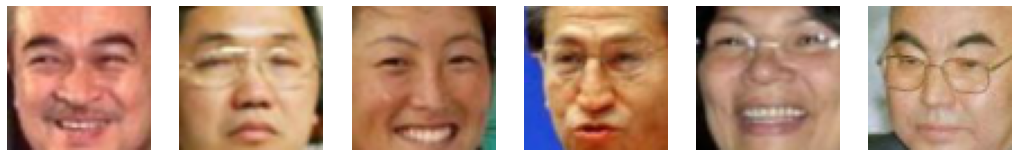

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[attrs[attrs['Asian']>1].index.values.tolist()[i]])
plt.show();

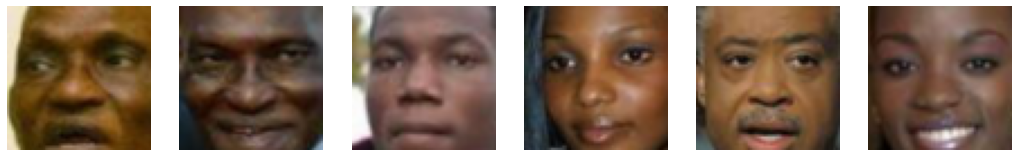

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[attrs[attrs['Black']>1].index.values.tolist()[i]])
plt.show();

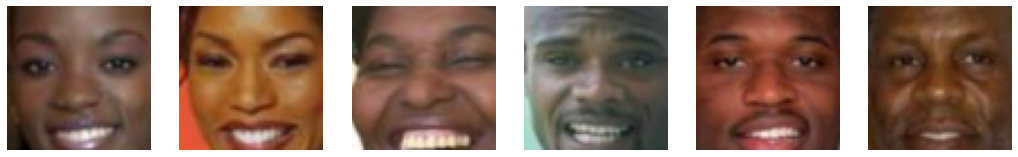

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[attrs[(attrs['Black']>1) & (attrs['Smiling']>1.5)].index.values.tolist()[i]])
plt.show();

In [ ]:
def load_data(dataset, test_split, batch_size):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - test_size

    train_dataset, test_dataset = torch.utils.data.dataset.random_split(dataset,
                                               [train_size, test_size])

    train_loader = DataLoader(
        train_dataset.dataset,
        batch_size=batch_size,
        shuffle=True)
    test_loader = DataLoader(
        test_dataset.dataset,
        batch_size=8,
        shuffle=True)

    return train_loader, test_loader 

In [ ]:
train, test = load_data(data, 0.8, 128)

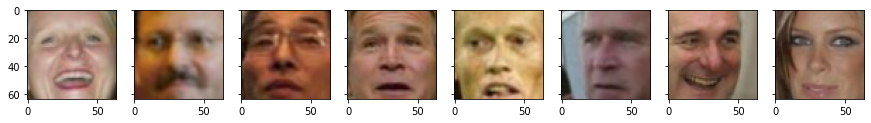

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(15, 15), \
                        sharey=True, sharex=True)



for fig_x in ax.flatten():
    iterator = iter(train)
    im_val = iterator.next()
    fig_x.imshow(im_val[0])


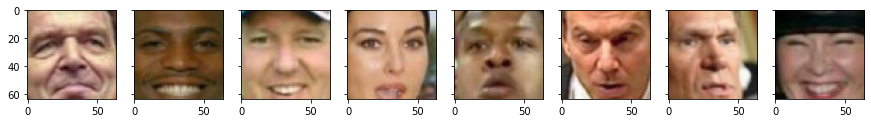

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=8,figsize=(15, 15), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    iterator = iter(test)
    im_val = iterator.next()
    fig_x.imshow(im_val[0])

Реализуем autoencoder

In [ ]:
dim_code = 256

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128 ),
            nn.Flatten(),
            nn.Linear(128*8*8, dim_code//2),
            nn.ReLU(True),
            nn.Linear(dim_code//2, dim_code)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, dim_code//2),
            nn.ReLU(True),
            nn.Linear(dim_code//2, 128 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, [128, 8, 8]),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(32, 3, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        out = self.decoder(latent_code)
        return out, latent_code

In [ ]:
criterion = nn.MSELoss();
model = Autoencoder().cuda()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=8192, out_features=128, bias=True)
    (14): ReLU(inplace=T

## Обучение

In [ ]:
unloader = transforms.ToPILImage()
plt.ion() 

def to_img(x):
    x = x.view(x.size(0), 3, 64, 64)
    return x


def imshow(plt_g, tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt_g.imshow(image)
    if title is not None:
        plt_g.set_title(title)

In [ ]:
num_epochs = 30
batch_size = 128
learning_rate = 3e-4

In [ ]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    train_losses_per_epoch = []
    for img in train:
        img = img.permute(0, 3, 1, 2).type(torch.FloatTensor).cuda()
        optimizer.zero_grad()
        output, _ = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    print('epoch: [{}/{}], loss:{:.4f}'
           .format(epoch+1, num_epochs, loss.item()))


    if epoch % 25 == 0:
        fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4), sharey=True, sharex=True)

        pic0 = to_img(img)
        pic = to_img(output.cpu().data)
        random_characters = int(np.random.uniform(0, pic0.shape[0]))
        for i in range(0, 10):
          imshow(ax[0][i], pic0[i], title='Оригинал')
          imshow(ax[1][i], pic[i], title='Реконструкция')
    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for img in test:
          img = img.permute(0, 3, 1, 2).type(torch.FloatTensor).cuda()
          reconstructed, lc = model(img)
          loss = criterion(reconstructed, img)
          val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))     

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

Модель не переобучается на 70 эпохах. Но после пятидесятой эпохи у модели не сильно изменился MSE loss

Как автоэнкодер восстанавливает картинки:

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4), \
                        sharey=True, sharex=True)
model.eval()
for i in range(0, 10):
    random_characters = int(np.random.uniform(0,data.shape[0]))
    im_val = data[random_characters]
    im_rec = torch.from_numpy(im_val).unsqueeze(0).permute(0, 3, 1, 2).type(torch.FloatTensor).cuda()
    im_rec, _ = model(im_rec)
    ax[0][i].imshow(im_val)
    ax[0][i].set_title("Or")
    pic_rec = to_img(im_rec.cpu().data)
    imshow(ax[1][i], pic_rec, "Re")

## Sampling

In [ ]:
from math import floor
z = np.random.randn(25, dim_code)
output = model.decoder(torch.from_numpy(z).type(torch.FloatTensor).cuda())

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(20, 20), \
                        sharey=True, sharex=True)

pic = to_img(output.cpu().data)
for i in range(0, 25):
  imshow(ax[floor(i/5)][i % 5], pic[i], title='R')

## Пририсовка улыбки людям :)

In [ ]:
smiles = data[attrs["Smiling"].sort_values(ascending=False).head(15).index]
sad = data[attrs["Smiling"].sort_values().head(15).index]

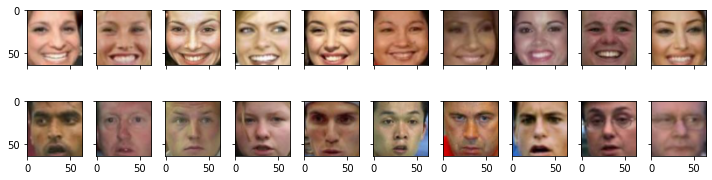

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(10, 3), sharey=True, sharex=True)
for i in range(10):
  ax[0][i].imshow(smiles[i])
  ax[1][i].imshow(sad[i])
fig.tight_layout()

In [ ]:
img_sm = torch.from_numpy(smiles).permute(0, 3, 1, 2).type(torch.FloatTensor).cuda()
img_sd = torch.from_numpy(sad).permute(0, 3, 1, 2).type(torch.FloatTensor).cuda()
lat_sm = model.encoder(img_sm)
lat_sd = model.encoder(img_sd)


In [ ]:
mean_sm = torch.mean(lat_sm, dim=0)
mean_sd = torch.mean(lat_sd, dim=0)
smile_vec = mean_sm - mean_sd

In [ ]:
smile_add = lat_sd + smile_vec
out_sd_sm = model.decoder(smile_add)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(20, 20), \
                        sharey=True, sharex=True)

pic_sm = to_img(out_sd_sm)
for i in range(0, 10):
  imshow(ax[i], pic_sm[i], title='Улыбка')

## Вариационный автоэнкодер

Скачаем датасет MNIST и обучим вариционный автоэнкодер:

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Реализация модели

In [ ]:
latent_dim = 2 # latent dimension for sampling
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=1, padding=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten()
        )
        
        self.mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.logsigma = nn.Linear(64 * 7 * 7, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, [64, 7, 7]),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=2)
        )


    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.mu(hidden)
        logsigma = self.logsigma(hidden)        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
          std = torch.exp(0.5 * logsigma)
          eps = torch.randn_like(std)
          sample = mu + (eps * std) 
          return sample
        else:
            return mu
    
    def decode(self, z):
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Функция для Los_vae, который состоит из KL-дивергенции и log-likelihood (в этом случае кросс-энтропия)

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)    

In [ ]:

criterion = loss_vae
autoencoder = VAE().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 100
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, _ in train_loader:
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, _ in test_loader:
          mu, logsigma, reconstruction = autoencoder(batch.to(device))
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

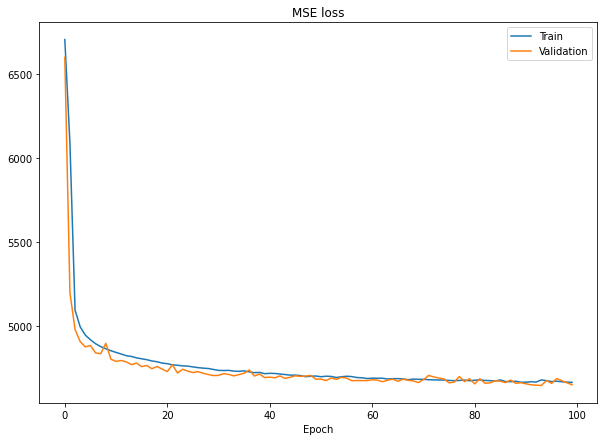

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

#plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [ ]:
def to_img_mnist(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow_mnist(plt_g, tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt_g.imshow(image, cmap='gray')
    if title is not None:
        plt_g.set_title(title)

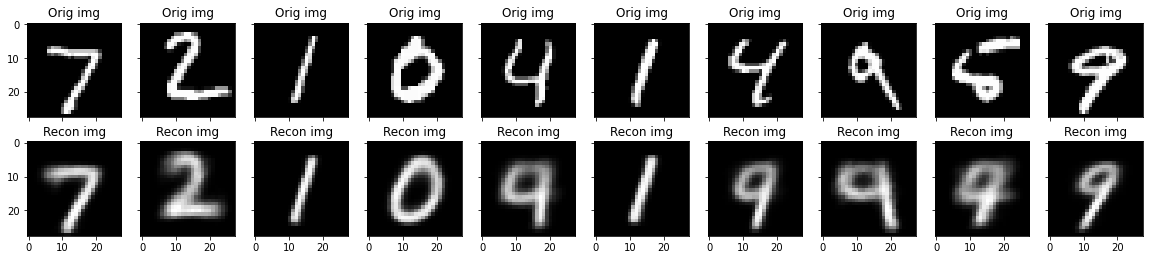

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4), \
                        sharey=True, sharex=True)
view_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)
autoencoder.eval()
v_iter =  iter(view_loader)
batch, _ = v_iter.next()
_, _, out = autoencoder(batch.to(device))
for i in range(0, batch.shape[0]):
    pic_o = to_img_mnist(batch[i])
    imshow_mnist(ax[0][i], pic_o, "Orig img")
    pic_r = to_img_mnist(out[i])
    imshow_mnist(ax[1][i], pic_r, "Recon img")

Пусть на вход decoder'у из VAE подаются случайные векторы из нормального распределения:

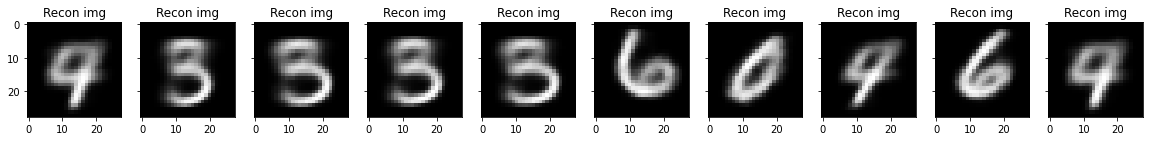

In [ ]:
z = np.array([np.random.normal(0, 1, 2) for i in range(10)])
autoencoder.eval()
x_hat = autoencoder.decode(torch.from_numpy(z).type(torch.FloatTensor).to(device))
fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(20, 4), \
                        sharey=True, sharex=True)

for i in range(0, 10):
    pic_o = to_img_mnist(x_hat[i])
    imshow_mnist(ax[i], pic_o, "Recon img")